In [1]:
%matplotlib inline

# Basic imports

In [2]:
import pandas as pd
import numpy as np
from Bio import SeqIO

from matplotlib import pyplot as plt

from scipy import stats
from Bio.Alphabet.IUPAC import IUPACProtein

import glob
import sklearn.metrics


###The following is used to create some sensible results folders according to the day
import datetime
year = datetime.date.today().year
month = datetime.date.today().month
import os
figs_dir = '../Results/Figures/{}_{:02}'.format(year, month)
if not os.path.exists(figs_dir):
    os.makedirs(figs_dir)

In [3]:
import matplotlib
matplotlib.rcParams['xtick.labelsize'] = 10
matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['axes.labelsize'] = 10
matplotlib.rcParams['axes.titlesize'] = 10

matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['grid.color'] = '0.5'
matplotlib.rcParams['grid.linewidth'] = '0.5'

matplotlib.rcParams['axes.edgecolor'] = '0.25'
matplotlib.rcParams['xtick.color'] = '0'
matplotlib.rcParams['ytick.color'] = '0'

matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1
matplotlib.rcParams['ytick.major.size'] = 5
matplotlib.rcParams['xtick.major.size'] = 5
matplotlib.rcParams['axes.spines.right'] = True
matplotlib.rcParams['axes.spines.left'] = True
matplotlib.rcParams['axes.spines.top'] = True
matplotlib.rcParams['axes.spines.bottom'] = True

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Helvetica'
matplotlib.rcParams['font.weight']='normal'
matplotlib.rcParams['axes.axisbelow'] = True


# Functions for parsing couplings and contacts dataframes

In [4]:
from supporting_functions import *

# Analysis of a single example protein

In [5]:
contact_number_modifier = 1 #This is how many top contacts to care about. A multiplier of sequence length
chain_cutoff = 12 #This is the parameter that ignores residues-residue pairs w/in a certain chain distance
metrics = ['CA', 'CB', 'SCcenter']
df_contacts_dict = {}
for metric in metrics:
    df_contacts_dict[metric] = {}

lengths = []
sequences = []
ppv_dict = {}
for metric in metrics:
    ppv_dict[metric] = []

CA_distance_cutoff = 8
CB_distance_cutoffs = []
SC_distance_cutoffs = []

prot_name = '1AOE_A'
couplings_file = '../Data/Empirical_couplings/{}_rp75.plmc.processed.couplings'.format(prot_name)

print('###', prot_name)
total_contacts = 0
cutoff=0
for metric in metrics:            
    df_couplings = pd.read_csv(couplings_file, sep=',')
    contact_file_loc = '../Data/Contact_matrices/{}_{}_contacts.csv'.format(prot_name, metric)
    try:
        df_contacts = pd.read_csv(contact_file_loc, index_col=0)
    except FileNotFoundError:
        print(couplings_file)
        continue
    df_contacts, df_contacts_stack = process_contacts_df(df_contacts, chain_cutoff)
    df_couplings_stack, df_couplings_pivot = process_couplings_df(df_couplings, df_contacts, chain_cutoff)
    records = list(SeqIO.parse('../Data/fastas/{}.fasta'.format(prot_name), 'fasta'))
    assert len(records)==1
    seq = str(records[0].seq)
    
    merged_df = merge_contacts_couplings(df_contacts_stack, df_couplings_stack, seq)
    number_to_test = round(len(df_contacts.index)* contact_number_modifier) 
    if metric == 'CA':
        total_contacts = merged_df[merged_df['distance']<CA_distance_cutoff]['distance'].count()
        ppv, counts = ppv_from_df(merged_df, number_to_test, length_cutoff=CA_distance_cutoff)
        print(metric, ppv, total_contacts)
    else:
        temp = df_contacts_stack.sort_values('distance')[:total_contacts]
        cutoff = temp.iloc[total_contacts-1]['distance']
        ppv, counts = ppv_from_df(merged_df, number_to_test, length_cutoff=cutoff)
        print(metric, ppv, len(temp.index), cutoff)
        if metric == 'CB':
            CB_distance_cutoffs.append(cutoff)
        elif metric == 'SCcenter':
            SC_distance_cutoffs.append(cutoff)

    if metric == 'CA':
        lengths.append(len(df_contacts.columns))
    df_contacts_dict[metric][prot_name] = df_contacts_stack

### 1AOE_A
CA 0.23958333333333334 295
CB 0.3177083333333333 295 7.500936508178711
SCcenter 0.3697916666666667 295 7.329545974731445


# Iterating through all available
**This will take a few minutes to run**

In [6]:
contact_number_modifier = 0.5
chain_cutoff = 12

coupling_method = 'ccmpred'
# coupling_method = 'plmc'
# coupling_method = 'psicov'



###Order here is important, CA has to come first to get distance thresholds for others
# metrics = ['CA', 'CB', 'SCcenter'] ###Order here is important, CA has to come first to get distance thresholds for others
metrics = ['CA', 'CB', 'SCcenter', 'all_atoms_min', 'sc_atoms_min'] ###Order here is important, CA has to come first to get distance thresholds for others

df_contacts_dict = {}
for metric in metrics:
    df_contacts_dict[metric] = {}

lengths = []
sequences = []
ppv_dict = {}
for metric in metrics:
    ppv_dict[metric] = []

CA_distance_cutoff = 8
CB_distance_cutoffs = {}
SC_distance_cutoffs = {}

for couplings_file in glob.glob('../Data/Empirical_couplings/'
                                '*.{}.processed.couplings'.format(coupling_method))[:]:
    prot_name = couplings_file.split('/')[-1].split('_')[0]+'_'+couplings_file.split('/')[-1].split('_')[1]
    alignment_file = couplings_file.replace('Empirical_couplings/', 'analyzed_fastas/')
    alignment_file = alignment_file.replace('.{}.processed.couplings'.format(coupling_method), '.mafft.processed.afa')
    
    
    alignments = list(SeqIO.parse(alignment_file, 'fasta'))
    nseqs = len(alignments)
    print('### {} ({})'.format(prot_name, nseqs))
    total_contacts = 0
    cutoff=0
    for metric in metrics:            
        df_couplings = pd.read_csv(couplings_file, sep=',')
        contact_file_loc = '../Data/Contact_matrices/{}_{}_contacts.csv'.format(prot_name, metric)
        try:
            df_contacts = pd.read_csv(contact_file_loc, index_col=0)
        except FileNotFoundError:
            print(couplings_file)
            continue
        df_contacts, df_contacts_stack = process_contacts_df(df_contacts, chain_cutoff)
        df_couplings_stack, df_couplings_pivot = process_couplings_df(df_couplings, df_contacts, chain_cutoff)
        records = list(SeqIO.parse('../Data/fastas/{}.rosetta.fasta'.format(prot_name), 'fasta'))
        assert len(records)==1
        seq = str(records[0].seq)
        merged_df = merge_contacts_couplings(df_contacts_stack, df_couplings_stack, seq)


        number_to_test = round(len(df_contacts.index)* contact_number_modifier) 
        if metric == 'CA':
            total_contacts = merged_df[merged_df['distance']<CA_distance_cutoff]['distance'].count()
            cutoff = CA_distance_cutoff
            lengths.append(len(df_contacts.columns))
            sequences.append(nseqs)
        else:
            temp = df_contacts_stack.sort_values('distance')[:total_contacts]
            cutoff = temp.iloc[total_contacts-1]['distance']
            print(metric, cutoff)
            if metric == 'CB':
                CB_distance_cutoffs[prot_name] = cutoff
            elif metric == 'SCcenter':
                SC_distance_cutoffs[prot_name] = cutoff

        ppv, counts = ppv_from_df(merged_df, number_to_test, length_cutoff=cutoff)
        ppv_dict[metric].append(ppv)
        df_contacts_dict[metric][prot_name] = df_contacts_stack

### 5PTP_A (9964)
CB 7.616451740264893
SCcenter 7.628875732421875
all_atoms_min 4.607858069680001
sc_atoms_min 6.262028746
### 1VFY_A (4623)
CB 7.6599273681640625
SCcenter 7.494290828704834
all_atoms_min 4.44112745375
sc_atoms_min 5.96543874368
### 1I71_A (3484)
CB 7.872744083404541
SCcenter 8.006433486938478
all_atoms_min 4.62446809601
sc_atoms_min 6.35249588281
### 1DQG_A (346)
CB 7.80859899520874
SCcenter 7.802220821380615
all_atoms_min 4.46669763729
sc_atoms_min 6.19703130431
### 1FNA_A (7886)
CB 7.940777778625487
SCcenter 8.163562774658201
all_atoms_min 4.60673857176
sc_atoms_min 6.676221786419999
### 1HXN_A (782)
CB 7.744203567504883
SCcenter 7.591279029846191
all_atoms_min 4.64605907092
sc_atoms_min 6.0993572375900005
### 1XKR_A (3503)
CB 7.46625280380249
SCcenter 7.16535234451294
all_atoms_min 4.378293789130001
sc_atoms_min 5.60303512752
### 1C52_A (3794)
CB 7.4511146545410165
SCcenter 7.289783954620361
all_atoms_min 4.27696083239
sc_atoms_min 5.548059604319999
### 2MHR_A (1062

# Visualizing diffs

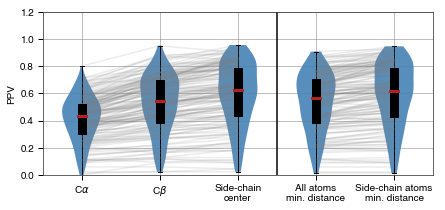

In [7]:
fig, ax = plt.subplots(figsize=(7,3.0))
parts = ax.violinplot([ppv_dict[metric] for metric in metrics], showextrema=False);

for pc in parts['bodies']:
    pc.set_facecolor('steelblue')
    pc.set_edgecolor('')
    pc.set_alpha(0.9)

bplot = ax.boxplot([ppv_dict[metric] for metric in metrics], patch_artist=True, widths=0.1);
for patch in bplot['boxes']:
    patch.set_facecolor('black')
for median in bplot['medians']:
    median.set(color='firebrick', linewidth=3,)
    
for i in range(len(lengths)):
    ax.plot([1,2,3], [ppv_dict['CA'][i], ppv_dict['CB'][i], ppv_dict['SCcenter'][i]],\
            color='gray', alpha=0.15)
    ax.plot([4,5], [ppv_dict['all_atoms_min'][i], ppv_dict['sc_atoms_min'][i]],\
            color='gray', alpha=0.15)
                      
ax.axvline(3.5, c='k')
    
ax.set_xticklabels([r'C$\alpha$', r'C$\beta$', 'Side-chain\ncenter',\
                   'All atoms\nmin. distance', 'Side-chain atoms\nmin. distance'])

ax.set_ylim(0, 1.2)
ax.set_ylabel('PPV')
# plt.savefig('{}/empirical_boxplots_large.pdf'.format(figs_dir), bbox_inches='tight')
# plt.savefig('{}/empirical_boxplots_psicov.pdf'.format(figs_dir), bbox_inches='tight')
# plt.savefig('{}/empirical_boxplots_plmc.pdf'.format(figs_dir), bbox_inches='tight')

**Statistical significance of any individual comparison**

In [8]:
# stats.wilcoxon(ppv_dict['CA'], ppv_dict['CB'])
stats.wilcoxon(ppv_dict['CB'], ppv_dict['SCcenter'])
# stats.wilcoxon(ppv_dict['all_atoms_min'], ppv_dict['sc_atoms_min'])
# stats.wilcoxon(ppv_dict['SCcenter'], ppv_dict['sc_atoms_min'])

WilcoxonResult(statistic=162.5, pvalue=7.095576890723085e-23)

In [9]:
for metric in metrics:
    print(metric, np.median(ppv_dict[metric]))

CA 0.43478260869565216
CB 0.5454545454545454
SCcenter 0.625
all_atoms_min 0.5675675675675675
sc_atoms_min 0.6190476190476191


**Visualizing individual metric comparisons**

#################
CB vs SCcenter
149 1.125
WilcoxonResult(statistic=162.5, pvalue=7.095576890723085e-23)


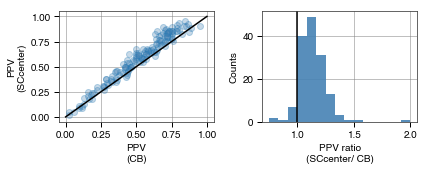

In [12]:
loglog=False
compare_a = 'CB'
compare_b = 'SCcenter'

fig, ax_arr = plt.subplots(nrows=1, ncols=2, figsize=(6, 2.5))
if not loglog:
    ax_arr[0].plot(ppv_dict[compare_a], ppv_dict[compare_b], marker='o',\
                   markerfacecolor='steelblue', linestyle='', alpha=0.3)
    ax_arr[0].plot([0,1], [0,1], 'k-')
else:
    ax_arr[0].loglog(ppv_dict[compare_a], ppv_dict[compare_b], marker='o',\
                    markerfacecolor='steelblue', linestyle='', alpha=0.3)
    ax_arr[0].loglog([0.1,1], [0.1,1], 'k-')

ax_arr[0].set_xlabel(r'PPV''\n'r'({})'.format(compare_a))
ax_arr[0].set_ylabel(r'PPV''\n'r'({})'.format(compare_b))


deltas = np.array(ppv_dict[compare_b]) / np.array(ppv_dict[compare_a])
deltas = deltas[~np.isnan(deltas)]
deltas = deltas[~np.isinf(deltas)]
ax_arr[1].hist(deltas, 15, facecolor='steelblue', alpha=0.9, normed=False)
ax_arr[1].axvline(1, color='k')
ax_arr[1].set_xlabel(r'PPV ratio''\n'r'({}/ {})'.format(compare_b, compare_a))
ax_arr[1].set_ylabel('Counts')
plt.tight_layout()
print('#################')
print('{} vs {}'.format(compare_a, compare_b))
print(len(ppv_dict[compare_a]), np.nanmedian(np.array(ppv_dict[compare_b])/np.array(ppv_dict[compare_a])))
print(stats.wilcoxon(ppv_dict[compare_a], ppv_dict[compare_b]))
# plt.savefig('{}/sc_vs_cb_empirical_fixed_thresh.pdf'.format(figs_dir), bbox_inches='tight')
# plt.savefig('{}/sc_vs_ca_empirical_psicov.pdf'.format(figs_dir), bbox_inches='tight')
# plt.savefig('{}/sc_vs_ca_empirical_plmc.pdf'.format(figs_dir), bbox_inches='tight')


**Some SI figs**

SpearmanrResult(correlation=0.665476114905053, pvalue=2.085854120027777e-20)
SpearmanrResult(correlation=0.6772082613375145, pvalue=2.491067973132064e-21)
SpearmanrResult(correlation=0.670890151634428, pvalue=7.918166221881315e-21)
SpearmanrResult(correlation=0.6603708215036702, pvalue=5.1051041651446544e-20)


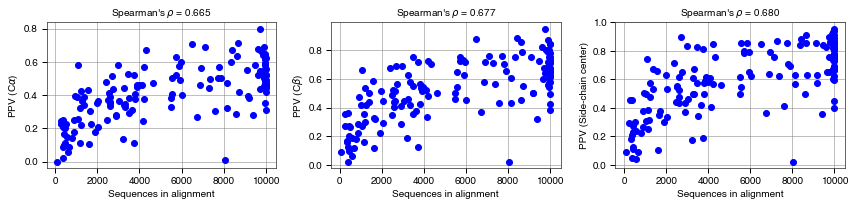

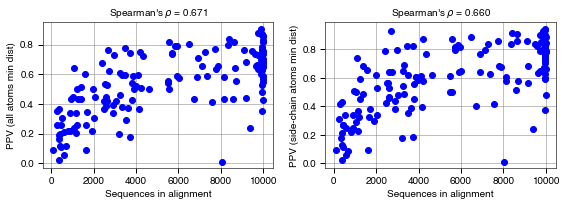

In [13]:
metric = 'CA'
fig, ax_arr = plt.subplots(nrows=1, ncols=3, figsize=(12,3))
ax_arr[0].plot(sequences, ppv_dict[metric], 'bo')
ax_arr[0].set_xlabel('Sequences in alignment')
ax_arr[0].set_ylabel('PPV ({})'.format(r'C$\alpha$'))
ax_arr[0].set_title(r"Spearman's $\rho$ = {0:.3f}".format(stats.spearmanr(sequences, ppv_dict[metric])[0]))
print(stats.spearmanr(sequences, ppv_dict[metric]))
metric = 'CB'
ax_arr[1].plot(sequences, ppv_dict[metric], 'bo')
ax_arr[1].set_xlabel('Sequences in alignment')
ax_arr[1].set_ylabel('PPV ({})'.format(r'C$\beta$'))
ax_arr[1].set_title(r"Spearman's $\rho$ = {0:.3f}".format(stats.spearmanr(sequences, ppv_dict[metric])[0]))
print(stats.spearmanr(sequences, ppv_dict[metric]))
metric = 'SCcenter'
ax_arr[2].plot(sequences, ppv_dict[metric], 'bo')
ax_arr[2].set_xlabel('Sequences in alignment')
ax_arr[2].set_ylabel('PPV ({})'.format(r'Side-chain center'))
ax_arr[2].set_title(r"Spearman's $\rho$ = {0:.3f}".format(stats.spearmanr(sequences, ppv_dict[metric])[0]))
plt.tight_layout()
# plt.savefig('{}/length_correlations.pdf'.format(figs_dir), bbox_inches='tight')


metric = 'all_atoms_min'
fig, ax_arr = plt.subplots(nrows=1, ncols=2, figsize=(8,3))
ax_arr[0].plot(sequences, ppv_dict[metric], 'bo')
ax_arr[0].set_xlabel('Sequences in alignment')
ax_arr[0].set_ylabel('PPV ({})'.format(r'all atoms min dist'))
ax_arr[0].set_title(r"Spearman's $\rho$ = {0:.3f}".format(stats.spearmanr(sequences, ppv_dict[metric])[0]))
print(stats.spearmanr(sequences, ppv_dict[metric]))
metric = 'sc_atoms_min'
ax_arr[1].plot(sequences, ppv_dict[metric], 'bo')
ax_arr[1].set_xlabel('Sequences in alignment')
ax_arr[1].set_ylabel('PPV ({})'.format(r'side-chain atoms min dist'))
ax_arr[1].set_title(r"Spearman's $\rho$ = {0:.3f}".format(stats.spearmanr(sequences, ppv_dict[metric])[0]))
print(stats.spearmanr(sequences, ppv_dict[metric]))
plt.tight_layout()

# Comparing angles

In [14]:
from collections import defaultdict

In [29]:
contact_number_modifier_list = [2, 1, 0.5, 0.25]
chain_cutoff = 12
metrics = ['CA', 'CB', 'SCcenter']

angles_ppv_dict = {}
for angle in ['both', 'one', 'none']:
    angles_ppv_dict[angle] = []

CA_distance_cutoff = 8
results_dict = defaultdict(list)
done = []

for couplings_file in glob.glob('../Data/Empirical_couplings/*.ccmpred.processed.couplings')[:]:
    prot_name = couplings_file.split('/')[-1].split('_')[0]+'_'+couplings_file.split('/')[-1].split('_')[1]
    alignment_file = couplings_file.replace('Empirical_couplings/', 'analyzed_fastas/')
    alignment_file = alignment_file.replace('.ccmpred.processed.couplings', '.mafft.processed.afa')
    alignments = list(SeqIO.parse(alignment_file, 'fasta'))
    nseqs = len(alignments)    
    if nseqs < 1000:
        continue
    print('### {} ({})'.format(prot_name, nseqs))
    total_contacts = 0
    cutoff=0
    for metric in metrics:
        df_couplings = pd.read_csv(couplings_file, sep=',')
        contact_file_loc = '../Data/Contact_matrices/{}_{}_contacts.csv'.format(prot_name, metric)
        try:
            df_contacts = pd.read_csv(contact_file_loc, index_col=0)
        except FileNotFoundError:
            print("no contacts file found:", couplings_file)
            continue


        df_contacts, df_contacts_stack = process_contacts_df(df_contacts, chain_cutoff)
        df_couplings_stack, df_couplings_pivot = process_couplings_df(df_couplings, df_contacts, chain_cutoff)
        records = list(SeqIO.parse('../Data/fastas/{}.rosetta.fasta'.format(prot_name), 'fasta'))
        assert len(records)==1
        seq = str(records[0].seq)
        merged_df = merge_contacts_couplings(df_contacts_stack, df_couplings_stack, seq)


        df_angles = pd.read_csv('../Data/Contact_matrices/{}_CA_angles.csv'.format(prot_name), index_col=0)
        df_angles.columns = df_angles.columns.astype(int)
        df_angles_stack = process_angles_df(df_angles, chain_cutoff)
        df_angles_stack['classification'] = 'none'
        df_angles_stack['classification'].where(~(df_angles_stack['angles1'] < np.pi/2) & ~(df_angles_stack['angles2'] < np.pi/2), 'one', inplace=True)
        df_angles_stack['classification'].where(~(df_angles_stack['angles1'] < np.pi/2) | ~(df_angles_stack['angles2'] < np.pi/2), 'both', inplace=True)
        df_angles_stack['classification'].where(~(df_angles_stack['angles1'].isnull()), np.nan, inplace=True)
        df_angles_stack['classification'].where(~(df_angles_stack['angles2'].isnull()), np.nan, inplace=True)

        merged_df = pd.concat([merged_df, df_angles_stack[['angles1', 'angles2', 'classification']]],\
                              axis=1, join_axes=[merged_df.index])

        if metric == 'CA':
            temp = merged_df[merged_df['distance'] < CA_distance_cutoff]['classification'].value_counts()
            results_dict[metric].append(temp['both']/sum(temp))


            temp = merged_df['classification'].value_counts()
            results_dict['All'].append(temp['both']/sum(temp))
            total_contacts = merged_df[merged_df['distance']<CA_distance_cutoff]['distance'].count()
    
            for contact_number_modifier in contact_number_modifier_list:
                number_to_test = round(len(df_contacts.index)* contact_number_modifier) 
                temp_df = merged_df[:number_to_test]

                temp = temp_df['classification'].value_counts()
                if 'both' in temp.keys():
                    results_dict['Couplings_{}'.format(contact_number_modifier)].append(temp['both']/sum(temp))
                else:
                    results_dict['Couplings_{}'.format(contact_number_modifier)].append(0)

        else:
            temp = merged_df.sort_values('distance')[:total_contacts]
            temp = temp['classification'].value_counts()
            results_dict[metric].append(temp['both']/sum(temp))
        done.append(prot_name)

In [20]:
np.median(results_dict['All']), np.median(results_dict['Couplings_1'])

(0.20431978501762904, 0.39955083707635775)

In [30]:
fig, ax = plt.subplots(figsize=(2.5,2.5))
labels = ['Top 0.25L', 'Top 0.5L', 'Top L', 'Top 2L', 'Side-chain',\
          r'C$\beta$', r'C$\alpha$', 'All pairs']
bplot = ax.boxplot([results_dict['All'], results_dict['CA'], results_dict['CB'], results_dict['SCcenter'],\
           results_dict['Couplings_2'], results_dict['Couplings_1'], results_dict['Couplings_0.5'],\
           results_dict['Couplings_0.25']][::-1],\
           labels = labels, vert=False, patch_artist=True);

for patch in bplot['boxes']:
    patch.set_facecolor('white')
ax.axhspan(7.5, 8.5, alpha=0.3, color='k')
ax.axhspan(4.5, 7.5, alpha=0.35, color='C4')
ax.axhspan(0, 4.5, alpha=0.35, color='C8')

ax.set_xlabel('Fraction of residue-residue\npairs with side-chains pointing\ntowards one-another')

# plt.savefig('{}/Side_chain_success.pdf'.format(figs_dir), bbox_inches='tight')

In [22]:
contact_number_modifier_list = [2, 1, 0.5, 0.25]
chain_cutoff = 12
metrics = ['CA', 'CB', 'SCcenter']

CA_distance_cutoff = 8

couplings_file = '../Data/Empirical_couplings/1AOE_A_rp75.ccmpred.processed.couplings'
prot_name = couplings_file.split('/')[-1].split('_')[0]+'_'+couplings_file.split('/')[-1].split('_')[1]
alignment_file = couplings_file.replace('Empirical_couplings/', 'analyzed_fastas/')
alignment_file = alignment_file.replace('.ccmpred.processed.couplings', '.mafft.processed.afa')
alignments = list(SeqIO.parse(alignment_file, 'fasta'))
nseqs = len(alignments)    

total_contacts = 0
cutoff=0

results_dict = {}

for metric in metrics:
    df_couplings = pd.read_csv(couplings_file, sep=',')
    contact_file_loc = '../Data/Contact_matrices/{}_{}_contacts.csv'.format(prot_name, metric)
    try:
        df_contacts = pd.read_csv(contact_file_loc, index_col=0)
    except FileNotFoundError:
        print("no contacts file found:", couplings_file)
        continue


    df_contacts, df_contacts_stack = process_contacts_df(df_contacts, chain_cutoff)
    df_couplings_stack, df_couplings_pivot = process_couplings_df(df_couplings, df_contacts, chain_cutoff)
    records = list(SeqIO.parse('../Data/fastas/{}.rosetta.fasta'.format(prot_name), 'fasta'))
    assert len(records)==1
    seq = str(records[0].seq)
    merged_df = merge_contacts_couplings(df_contacts_stack, df_couplings_stack, seq)


    df_angles = pd.read_csv('../Data/Contact_matrices/{}_CA_angles.csv'.format(prot_name), index_col=0)
    df_angles.columns = df_angles.columns.astype(int)
    df_angles_stack = process_angles_df(df_angles, chain_cutoff)
    df_angles_stack['classification'] = 'none'
    df_angles_stack['classification'].where(~(df_angles_stack['angles1'] < np.pi/2) & ~(df_angles_stack['angles2'] < np.pi/2), 'one', inplace=True)
    df_angles_stack['classification'].where(~(df_angles_stack['angles1'] < np.pi/2) | ~(df_angles_stack['angles2'] < np.pi/2), 'both', inplace=True)
    df_angles_stack['classification'].where(~(df_angles_stack['angles1'].isnull()), np.nan, inplace=True)
    df_angles_stack['classification'].where(~(df_angles_stack['angles2'].isnull()), np.nan, inplace=True)

    merged_df = pd.concat([merged_df, df_angles_stack[['angles1', 'angles2', 'classification']]],\
                          axis=1, join_axes=[merged_df.index])

    if metric == 'CA':
        temp = merged_df[merged_df['distance'] < CA_distance_cutoff]['classification'].value_counts()
        results_dict[metric] = (temp['both'], temp['one'], temp['none'])
        total_contacts = merged_df[merged_df['distance']<CA_distance_cutoff]['distance'].count()
        temp2 = merged_df['classification'].value_counts()
        results_dict['All'] = (temp2['both'], temp2['one'], temp2['none'])

    else:
        temp = merged_df.sort_values('distance')[:total_contacts]
        temp = temp['classification'].value_counts()
        results_dict[metric] = (temp['both'], temp['one'], temp['none'])

**For a single example protein**

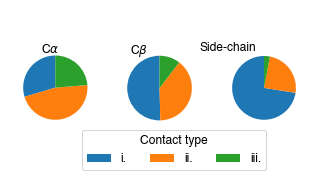

In [25]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['i.', 'ii.', 'iii.']
sizes = results_dict['CA']

fig1, ax_arr = plt.subplots(nrows=1, ncols=3, figsize=(4.5,1.5))
patches, texts = ax_arr[0].pie(sizes, startangle=90)
ax_arr[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

sizes = results_dict['CB']
patches, texts = ax_arr[1].pie(sizes, startangle=90)
ax_arr[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


sizes = results_dict['SCcenter']
patches, texts = ax_arr[2].pie(sizes, startangle=90)
ax_arr[2].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

legend = ax_arr[1].legend(patches, labels, ncol=3, bbox_to_anchor=(0.8, -0.05, 1., .102), fontsize=12, title='Contact type')
legend.get_title().set_fontsize('12') #legend 'Title' fontsize

textstr1 = r'C$\alpha$'
props = dict(boxstyle='square', facecolor='white', edgecolor='white', alpha=0)
ax_arr[0].text(0.05, 0.55, textstr1, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

textstr2 = r'C$\beta$'

props = dict(boxstyle='square', facecolor='white', edgecolor='white', alpha=0)
ax_arr[1].text(0.51, 0.55, textstr2, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
plt.tight_layout()

textstr3 = 'Side-chain'
props = dict(boxstyle='square', facecolor='white', edgecolor='white', alpha=0)
ax_arr[1].text(0.87, 0.55, textstr3, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
plt.tight_layout()

# plt.savefig('{}/Side_chain_pie.pdf'.format(figs_dir), bbox_inches='tight')

# Fixed distance thresholds for contact identification

**In this analysis I fix the threshold for contact identification for each metric. This has the consequence that for the same protein, different contact identification metrics may/will have very different numbers of *possible* identified contacts. Doing so makes physical sense, but makes comparisons between metrics more difficult (impossible?) since if one structural metric predicts half the number of residue-residue interactions, the PPV of couplings will obviously be much lower for that metric since the "target" is half the size**

In [33]:
contact_number_modifier = 0.5
chain_cutoff = 12

coupling_method = 'ccmpred'
# coupling_method = 'plmc'
# coupling_method = 'psicov'



###Order here is important, CA has to come first to get distance thresholds for others
# metrics = ['CA', 'CB', 'SCcenter'] ###Order here is important, CA has to come first to get distance thresholds for others
metrics = ['CA', 'CB', 'SCcenter', 'all_atoms_min', 'sc_atoms_min'] ###Order here is important, CA has to come first to get distance thresholds for others

df_contacts_dict = {}
for metric in metrics:
    df_contacts_dict[metric] = {}

lengths = []
sequences = []
ppv_dict = {}
for metric in metrics:
    ppv_dict[metric] = []

distance_cutoff_dict = {}
distance_cutoff_dict['CA'] = 8.
distance_cutoff_dict['CB'] = 7.6
distance_cutoff_dict['SCcenter'] = 7.5
distance_cutoff_dict['all_atoms_min'] = 4.5
distance_cutoff_dict['sc_atoms_min'] = 4.5

true_contacts = {}
for metric in metrics:
    true_contacts[metric] = []

for couplings_file in glob.glob('../Data/Empirical_couplings/'
                                '*.{}.processed.couplings'.format(coupling_method))[:10]:
    prot_name = couplings_file.split('/')[-1].split('_')[0]+'_'+couplings_file.split('/')[-1].split('_')[1]
    alignment_file = couplings_file.replace('Empirical_couplings/', 'analyzed_fastas/')
    alignment_file = alignment_file.replace('.{}.processed.couplings'.format(coupling_method), '.mafft.processed.afa')
    
    
    alignments = list(SeqIO.parse(alignment_file, 'fasta'))
    nseqs = len(alignments)
    print('### {} ({})'.format(prot_name, nseqs))
    total_contacts = 0
    cutoff=0
    for metric in metrics:            
        df_couplings = pd.read_csv(couplings_file, sep=',')
        contact_file_loc = '../Data/Contact_matrices/{}_{}_contacts.csv'.format(prot_name, metric)
        try:
            df_contacts = pd.read_csv(contact_file_loc, index_col=0)
        except FileNotFoundError:
            print(couplings_file)
            continue
        df_contacts, df_contacts_stack = process_contacts_df(df_contacts, chain_cutoff)
        df_couplings_stack, df_couplings_pivot = process_couplings_df(df_couplings, df_contacts, chain_cutoff)
        records = list(SeqIO.parse('../Data/fastas/{}.rosetta.fasta'.format(prot_name), 'fasta'))
        assert len(records)==1
        seq = str(records[0].seq)
        merged_df = merge_contacts_couplings(df_contacts_stack, df_couplings_stack, seq)


        number_to_test = round(len(df_contacts.index)* contact_number_modifier) 
        if metric == 'CA':
            lengths.append(len(df_contacts.columns))
            sequences.append(nseqs)
    
        cutoff = distance_cutoff_dict[metric]

        n_contacts = merged_df[merged_df['distance']<distance_cutoff_dict[metric]]['distance'].count()
        n_total = merged_df['distance'].count()
        ppv, counts = ppv_from_df(merged_df, number_to_test, length_cutoff=cutoff)
        print(ppv, (n_contacts/n_total))
        ppv_dict[metric].append(ppv)
        df_contacts_dict[metric][prot_name] = df_contacts_stack
        true_contacts[metric].append(n_contacts)

**Illustrating that this method is insufficient to compare the `all_atom_min_dist` and `sc_atom_min_dist` methods**

In [32]:
fig, ax = plt.subplots(figsize=(7,3.0))
parts = ax.violinplot([true_contacts[metric] for metric in metrics], showextrema=False);

for pc in parts['bodies']:
    pc.set_facecolor('darkorange')
    pc.set_edgecolor('')
    pc.set_alpha(0.7)

bplot = ax.boxplot([true_contacts[metric] for metric in metrics], patch_artist=True, widths=0.1);
for patch in bplot['boxes']:
    patch.set_facecolor('black')
for median in bplot['medians']:
    median.set(color='firebrick', linewidth=3,)
ax.axvline(3.5, c='k')

 
for i in range(len(lengths)):
    ax.plot([1,2,3,4,5], [true_contacts['CA'][i], true_contacts['CB'][i], true_contacts['SCcenter'][i],\
                     true_contacts['all_atoms_min'][i], true_contacts['sc_atoms_min'][i]],\
            color='gray', alpha=0.15)
ax.set_ylim(0, 750)   
ax.set_xticklabels([r'C$\alpha$'+'\n(8$\AA$)', r'C$\beta$'+'\n(7.6$\AA$)', 'Side-chain\ncenter\n(7.5$\AA$)',\
                   'All atoms\nmin. distance\n(4.5$\AA$)', 'Side-chain atoms\nmin. distance\n(4.5$\AA$)'])

ax.set_ylabel('# of contacts identified in structure')
# plt.savefig('{}/n_contacts_identified.pdf'.format(figs_dir), bbox_inches='tight')

In [ ]:
# stats.wilcoxon(true_contacts['CA'], true_contacts['CB'])
# stats.wilcoxon(true_contacts['CB'], true_contacts['SCcenter'])
# stats.wilcoxon(true_contacts['CA'], true_contacts['SCcenter'])
stats.wilcoxon(true_contacts['all_atoms_min'], true_contacts['sc_atoms_min'])


In [ ]:
for metric in metrics:
    print(metric, np.median(true_contacts[metric]))

In [ ]:
fig, ax = plt.subplots(figsize=(7,3.0))
parts = ax.violinplot([ppv_dict[metric] for metric in metrics[:3]], showextrema=False);

for pc in parts['bodies']:
    pc.set_facecolor('steelblue')
    pc.set_edgecolor('')
    pc.set_alpha(0.9)

bplot = ax.boxplot([ppv_dict[metric] for metric in metrics[:3]], patch_artist=True, widths=0.1);
for patch in bplot['boxes']:
    patch.set_facecolor('black')
for median in bplot['medians']:
    median.set(color='firebrick', linewidth=3,)
    
for i in range(len(lengths)):
    ax.plot([1,2,3], [ppv_dict['CA'][i], ppv_dict['CB'][i], ppv_dict['SCcenter'][i]],\
            color='gray', alpha=0.15)
                          
ax.set_xticklabels([r'C$\alpha$', r'C$\beta$', 'Side-chain\ncenter'])
ax.set_ylim(0, 1.2)
ax.set_ylabel('PPV')
# plt.savefig('{}/empirical_boxplots_fixed_thresh.pdf'.format(figs_dir), bbox_inches='tight')

In [ ]:
# stats.wilcoxon(ppv_dict['CA'], ppv_dict['CB'])
# stats.wilcoxon(ppv_dict['CB'], ppv_dict['SCcenter'])
# stats.wilcoxon(ppv_dict['CA'], ppv_dict['SCcenter'])

In [ ]:
for metric in metrics:
    print(metric, np.median(ppv_dict[metric]))

# So instead quantify the average precision score (or the average precision score minus expected) for this comparison

In [ ]:
contact_number_modifier = 0.5
chain_cutoff = 12

coupling_method = 'ccmpred'
# coupling_method = 'plmc'
# coupling_method = 'psicov'



###Order here is important, CA has to come first to get distance thresholds for others
# metrics = ['CA', 'CB', 'SCcenter'] ###Order here is important, CA has to come first to get distance thresholds for others
metrics = ['all_atoms_min', 'sc_atoms_min'] ###Order here is important, CA has to come first to get distance thresholds for others

df_contacts_dict = {}
for metric in metrics:
    df_contacts_dict[metric] = {}

lengths = []
sequences = []
ppv_dict = {}
for metric in metrics:
    ppv_dict[metric] = []

distance_cutoff_dict = {}
distance_cutoff_dict['all_atoms_min'] = 4.5
distance_cutoff_dict['sc_atoms_min'] = 4.5

true_contacts = {}
for metric in metrics:
    true_contacts[metric] = []

for couplings_file in glob.glob('../Data/Empirical_couplings/'
                                '*.{}.processed.couplings'.format(coupling_method))[:]:
    prot_name = couplings_file.split('/')[-1].split('_')[0]+'_'+couplings_file.split('/')[-1].split('_')[1]
    alignment_file = couplings_file.replace('Empirical_couplings/', 'analyzed_fastas/')
    alignment_file = alignment_file.replace('.{}.processed.couplings'.format(coupling_method), '.mafft.processed.afa')
    
    
    alignments = list(SeqIO.parse(alignment_file, 'fasta'))
    nseqs = len(alignments)
    print('### {} ({})'.format(prot_name, nseqs))
    total_contacts = 0
    cutoff=0
    for metric in metrics:            
        df_couplings = pd.read_csv(couplings_file, sep=',')
        contact_file_loc = '../Data/Contact_matrices/{}_{}_contacts.csv'.format(prot_name, metric)
        try:
            df_contacts = pd.read_csv(contact_file_loc, index_col=0)
        except FileNotFoundError:
            print(couplings_file)
            continue
        df_contacts, df_contacts_stack = process_contacts_df(df_contacts, chain_cutoff)
        df_couplings_stack, df_couplings_pivot = process_couplings_df(df_couplings, df_contacts, chain_cutoff)
        records = list(SeqIO.parse('../Data/fastas/{}.rosetta.fasta'.format(prot_name), 'fasta'))
        assert len(records)==1
        seq = str(records[0].seq)
        merged_df = merge_contacts_couplings(df_contacts_stack, df_couplings_stack, seq)


        number_to_test = round(len(df_contacts.index)* contact_number_modifier) 
        if metric == 'CA':
            lengths.append(len(df_contacts.columns))
            sequences.append(nseqs)
    
        cutoff = distance_cutoff_dict[metric]
        ####Using PPV
        n_contacts = merged_df[merged_df['distance']<distance_cutoff_dict[metric]]['distance'].count()
        n_total = merged_df['distance'].count()
#         ppv, counts = ppv_from_df(merged_df, number_to_test, length_cutoff=cutoff)
#         print(ppv, (n_contacts/n_total))
#         ppv_dict[metric].append(ppv/(n_contacts/n_total))
#         df_contacts_dict[metric][prot_name] = df_contacts_stack
#         true_contacts[metric].append(n_contacts)
        
        ####Testing AUPR
        merged_df['contact'] = np.where(merged_df['distance']>=4.5, 0, 1)
        aupr = sklearn.metrics.average_precision_score(merged_df['contact'], merged_df['couplings'])
        ppv_dict[metric].append(aupr)
#         ppv_dict[metric].append(aupr-(n_contacts/n_total))


In [ ]:
fig, ax = plt.subplots(figsize=(7,3.0))
parts = ax.violinplot([ppv_dict[metric] for metric in metrics], showextrema=False);

for pc in parts['bodies']:
    pc.set_facecolor('steelblue')
    pc.set_edgecolor('')
    pc.set_alpha(0.9)

bplot = ax.boxplot([ppv_dict[metric] for metric in metrics], patch_artist=True, widths=0.1);
for patch in bplot['boxes']:
    patch.set_facecolor('black')
for median in bplot['medians']:
    median.set(color='firebrick', linewidth=3,)
    
for i in range(len(ppv_dict[metrics[0]])):
    ax.plot([1,2], [ppv_dict['all_atoms_min'][i], ppv_dict['sc_atoms_min'][i]],\
            color='gray', alpha=0.15)
ax.set_ylim(-0.05,0.7)
ax.set_xticklabels(['All atoms\nmin. distance\n(4.5$\AA$)', 'Side-chain atoms\nmin. distance\n(4.5$\AA$)'])
ax.set_ylabel('Average precision score')
plt.savefig('{}/min_dists_APS.pdf'.format(figs_dir), bbox_inches='tight')
# ax.set_ylabel('Average precision score - expected')
# plt.savefig('{}/min_dists_relAPS.pdf'.format(figs_dir), bbox_inches='tight')

In [ ]:
for metric in metrics:
    print(metric, np.median(ppv_dict[metric]))

In [ ]:
stats.wilcoxon(ppv_dict['all_atoms_min'], ppv_dict['sc_atoms_min'])

**While we're here might as well look at aupr scores for everyone right?**

In [ ]:
contact_number_modifier = 0.5
chain_cutoff = 12

coupling_method = 'ccmpred'
# coupling_method = 'plmc'
# coupling_method = 'psicov'



###Order here is important, CA has to come first to get distance thresholds for others
# metrics = ['CA', 'CB', 'SCcenter'] ###Order here is important, CA has to come first to get distance thresholds for others
metrics = ['CA', 'CB', 'SCcenter', 'all_atoms_min', 'sc_atoms_min'] ###Order here is important, CA has to come first to get distance thresholds for others

df_contacts_dict = {}
for metric in metrics:
    df_contacts_dict[metric] = {}

lengths = []
sequences = []
ppv_dict = {}
for metric in metrics:
    ppv_dict[metric] = []

distance_cutoff_dict = {}
distance_cutoff_dict['CA'] = 8.
distance_cutoff_dict['CB'] = 7.6
distance_cutoff_dict['SCcenter'] = 7.5
distance_cutoff_dict['all_atoms_min'] = 4.5
distance_cutoff_dict['sc_atoms_min'] = 4.5

true_contacts = {}
for metric in metrics:
    true_contacts[metric] = []

for couplings_file in glob.glob('../Data/Empirical_couplings/'
                                '*.{}.processed.couplings'.format(coupling_method))[:]:
    prot_name = couplings_file.split('/')[-1].split('_')[0]+'_'+couplings_file.split('/')[-1].split('_')[1]
    alignment_file = couplings_file.replace('Empirical_couplings/', 'analyzed_fastas/')
    alignment_file = alignment_file.replace('.{}.processed.couplings'.format(coupling_method), '.mafft.processed.afa')
    
    
    alignments = list(SeqIO.parse(alignment_file, 'fasta'))
    nseqs = len(alignments)
    print('### {} ({})'.format(prot_name, nseqs))
    total_contacts = 0
    cutoff=0
    for metric in metrics:            
        df_couplings = pd.read_csv(couplings_file, sep=',')
        contact_file_loc = '../Data/Contact_matrices/{}_{}_contacts.csv'.format(prot_name, metric)
        try:
            df_contacts = pd.read_csv(contact_file_loc, index_col=0)
        except FileNotFoundError:
            print(couplings_file)
            continue
        df_contacts, df_contacts_stack = process_contacts_df(df_contacts, chain_cutoff)
        df_couplings_stack, df_couplings_pivot = process_couplings_df(df_couplings, df_contacts, chain_cutoff)
        records = list(SeqIO.parse('../Data/fastas/{}.rosetta.fasta'.format(prot_name), 'fasta'))
        assert len(records)==1
        seq = str(records[0].seq)
        merged_df = merge_contacts_couplings(df_contacts_stack, df_couplings_stack, seq)


        number_to_test = round(len(df_contacts.index)* contact_number_modifier) 
        if metric == 'CA':
            lengths.append(len(df_contacts.columns))
            sequences.append(nseqs)
    
        cutoff = distance_cutoff_dict[metric]
        ####Testing AUPR
        merged_df['contact'] = np.where(merged_df['distance']>=distance_cutoff_dict[metric], 0, 1)
        aupr = sklearn.metrics.average_precision_score(merged_df['contact'], merged_df['couplings'])
        ppv_dict[metric].append(aupr)
        n_contacts = merged_df[merged_df['distance']<distance_cutoff_dict[metric]]['distance'].count()
        df_contacts_dict[metric][prot_name] = df_contacts_stack
        true_contacts[metric].append(n_contacts)

In [ ]:
fig, ax = plt.subplots(figsize=(7,3.0))
parts = ax.violinplot([ppv_dict[metric] for metric in metrics], showextrema=False);

for pc in parts['bodies']:
    pc.set_facecolor('steelblue')
    pc.set_edgecolor('')
    pc.set_alpha(0.9)

bplot = ax.boxplot([ppv_dict[metric] for metric in metrics], patch_artist=True, widths=0.1);
for patch in bplot['boxes']:
    patch.set_facecolor('black')
for median in bplot['medians']:
    median.set(color='firebrick', linewidth=3,)
    
for i in range(len(lengths)):
    ax.plot([1,2,3], [ppv_dict['CA'][i], ppv_dict['CB'][i], ppv_dict['SCcenter'][i]],\
            color='gray', alpha=0.15)
    ax.plot([4,5], [ppv_dict['all_atoms_min'][i], ppv_dict['sc_atoms_min'][i]],\
            color='gray', alpha=0.15)
                      
ax.axvline(3.5, c='k')
    
ax.set_xticklabels([r'C$\alpha$', r'C$\beta$', 'Side-chain\ncenter',\
                   'All atoms\nmin. distance', 'Side-chain atoms\nmin. distance'])

ax.set_ylim(0, 0.7)
ax.set_ylabel('Average Precision Score')
plt.savefig('{}/empirical_boxplots_large_aps.pdf'.format(figs_dir), bbox_inches='tight')
# plt.savefig('{}/empirical_boxplots_psicov.pdf'.format(figs_dir), bbox_inches='tight')
# plt.savefig('{}/empirical_boxplots_plmc.pdf'.format(figs_dir), bbox_inches='tight')

In [ ]:
for metric in metrics:
    print(metric, np.median(ppv_dict[metric]))

In [ ]:
# stats.wilcoxon(ppv_dict['CA'], ppv_dict['CB'])
# stats.wilcoxon(ppv_dict['CB'], ppv_dict['SCcenter'])
# stats.wilcoxon(ppv_dict['CA'], ppv_dict['SCcenter'])
stats.wilcoxon(ppv_dict['all_atoms_min'], ppv_dict['sc_atoms_min'])
# stats.wilcoxon(ppv_dict['sc_atoms_min'], ppv_dict['SCcenter'])

In [ ]:
fig, ax = plt.subplots()
ax.hist(np.array(ppv_dict['SCcenter'])-np.array(ppv_dict['sc_atoms_min']))